In [24]:
import numpy as np
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
matplotlib.rcParams.update({'legend.labelcolor': 'black'})

pi = np.pi                  # Valor de π

# Espectro teórico de mar

Tipos de Espectro:

* Pierson-Moskowitz
* Bretschneider
* JONSWAP
* Ochi-Hubble
* Torsethaugen 

## Espectro de JONSWAP

$$
S_w = \frac{1}{2\pi} \cdot \frac{5}{16} \cdot h_s^2 \cdot t_p \cdot \left(\frac{\frac{2\pi}{t_p}}{w}\right)^5 \cdot (1 - 0.287 \cdot \log(\gamma)) \cdot \exp\left(-1.25 \cdot \left(\frac{w}{2\pi/t_p}\right)^{-4}\right) \cdot \gamma^{\exp\left(-\frac{\left(w - \frac{2\pi}{t_p}\right)^2}{2 \cdot \sigma^2 \cdot \left(\frac{\frac{2\pi}{t_p}}{2\pi}\right)^2}\right)}
$$

onde:
$$
\sigma = \begin{cases}
0.07 & \text{se } w \leq \frac{2\pi}{t_p} \\
0.09 & \text{se } w > \frac{2\pi}{t_p}
\end{cases}
$$

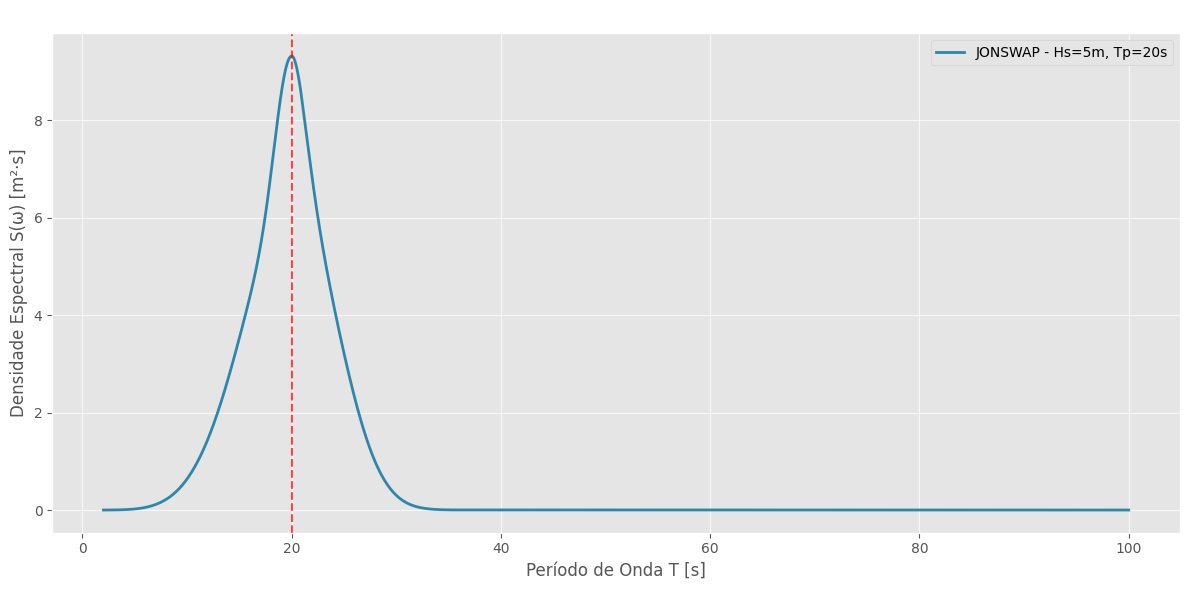

In [25]:
# PARÂMETROS DA SIMULAÇÃO
N = 5000                    # Número de pontos para discretização do espectro
tp = 20                     # Período de pico (s) - período onde ocorre a máxima energia
hs = 5                      # Altura significativa (m) - altura média do terço mais alto das ondas

# VETOR DE FREQUÊNCIAS ANGULARES
# Define o range de frequências correspondente a períodos entre 2s e 100s
w = np.linspace(2*pi/100, 2*pi/2, N)

# DEFINIÇÃO DO ESPECTRO JONSWAP
def jonswap(hs, tp):
    """
    Calcula o espectro de energia JONSWAP para condições de mar gerado pelo vento.
    
    Parâmetros:
    hs : float - Altura significativa de onda (m)
    tp : float - Período de pico (s)
    
    Retorna:
    Sw : array - Densidade espectral de energia (m²·s/rad)
    """
    # Fator de pico de forma (γ) - determina a agudez do pico espectral
    # Valores típicos: 1-7 (1=Pierson-Moskowitz, >1=espectro mais pontiagudo)
    gama = 6.4 * tp**-0.491
    
    # ESPECTRO JONSWAP - Componentes:
    # 1. Termo de normalização: (2π)⁻¹
    # 2. Termo de escala: (5/16)hs²tp
    # 3. Decaimento de alta frequência: ((ωp/ω)⁵)exp(-1.25(ω/ωp)⁻⁴)
    # 4. Fator de pico: γ^exp(-(ω-ωp)²/(2σ²ωp²))
    
    omega_p = 2*pi/tp  # Frequência angular de pico (rad/s)
    
    Sw = ((2*pi)**-1 * (5/16) * hs**2 * tp * 
          ((omega_p)/w)**5 *
          (1 - 0.287 * np.log(gama)) * 
          np.exp(-1.25 * (w/omega_p)**-4) *
          gama**np.exp(-((w - omega_p)/(2*pi))**2 / 
                      (2 * ((w <= omega_p) * 0.07 + (w > omega_p) * 0.09)**2 * 
                       (omega_p/(2*pi))**2)))
    
    return Sw

# CÁLCULO DO ESPECTRO
Sw = jonswap(hs, tp)

# PLOTAGEM DO ESPECTRO NO DOMÍNIO DO PERÍODO
plt.figure(figsize=(12, 6))
plt.plot(2*pi/w, Sw, linewidth=2, color='#2E86AB', label=f'JONSWAP - Hs={hs}m, Tp={tp}s')

# Configurações do gráfico
plt.ylabel('Densidade Espectral S(ω) [m²·s]', fontsize=12)
plt.xlabel('Período de Onda T [s]', fontsize=12)
plt.title('Espectro de Energia de Ondas - Modelo JONSWAP', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.7)
plt.legend()

# Adiciona linhas de referência para o período de pico
plt.axvline(x=tp, color='red', linestyle='--', alpha=0.7, label=f'Período de Pico (Tp={tp}s)')

# Ajusta os limites do eixo x para melhor visualização
#plt.xlim(0, 100)

plt.tight_layout()
plt.show()

In [26]:
# CÁLCULO DOS PARÂMETROS CARACTERÍSTICOS DO ESPECTRO

# Encontra o índice do pico espectral
idx_pico = np.argmax(Sw)
T_pico = 2*pi/w[idx_pico]
S_max = Sw[idx_pico]

print("  CARACTERÍSTICAS DO ESPECTRO:")
print(f"  • Altura significativa (Hs): {hs} m")
print(f"  • Fator de pico (γ): {6.4 * tp**-0.491:.3f}")
print(f"  • Período no pico espectral: {T_pico:.2f} s")
print(f"  • Densidade espectral máxima: {S_max:.4f} m²·s")
print(f"  • Frequência de pico: {w[idx_pico]:.3f} rad/s")

# Cálculo da altura significativa a partir do espectro
m0 = np.trapezoid(Sw, w)
Hs_calculado = 4 * np.sqrt(m0)
print(f"  • Hs calculado do espectro: {Hs_calculado:.3f} m")

  CARACTERÍSTICAS DO ESPECTRO:
  • Altura significativa (Hs): 5 m
  • Fator de pico (γ): 1.470
  • Período no pico espectral: 20.00 s
  • Densidade espectral máxima: 9.3162 m²·s
  • Frequência de pico: 0.314 rad/s
  • Hs calculado do espectro: 4.992 m


In [27]:
# Cálculo dos momentos espectrais
# m0 = ∫S(w)dw  (Energia total do espectro)
# m2 = ∫w²S(w)dw (Momento relacionado à frequência)

m0_teo = np.trapezoid(Sw, w)                    # Variância da elevação da superfície
m2_teo = np.trapezoid(Sw * (w**2), w)           # Relacionado à aceleração das ondas

# Parâmetros hidrodinâmicos derivados
Hs_teo = 4 * np.sqrt(m0_teo)                    # Hs = 4√m0 (Altura significativa)
Tz_teo = 2 * np.pi * np.sqrt(m0_teo / m2_teo)   # Tz = 2π√(m0/m2) (Período médio)

# Resultados
print(f"   Energia total do espectro (m0): {m0_teo:8.4f} m²")
print(f"   Momento espectral de 2ª ordem (m2): {m2_teo:8.4f} m²/rad²")
print(f"   Altura significativa (Hs): {Hs_teo:8.2f} m")
print(f"   Período de cruzamento por zero (Tz): {Tz_teo:8.2f} s")

   Energia total do espectro (m0):   1.5572 m²
   Momento espectral de 2ª ordem (m2):   0.2855 m²/rad²
   Altura significativa (Hs):     4.99 m
   Período de cruzamento por zero (Tz):    14.67 s


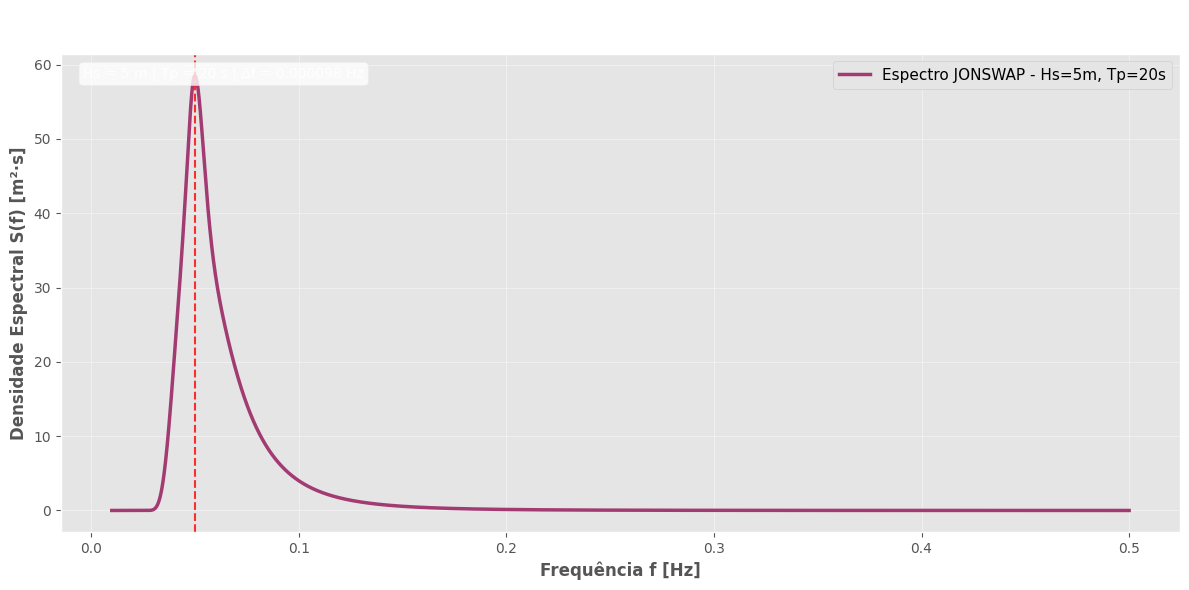

  CONVERSÃO PARA DOMÍNIO DA FREQUÊNCIA
Parâmetros de conversão:
  • Frequência mínima: 0.0100 Hz
  • Frequência máxima: 0.5000 Hz
  • Resolução em frequência (Δf): 0.000098 Hz
  • Frequência de pico teórica: 0.0500 Hz

  Verificação da conservação de energia:
  • m0 no domínio ω: 1.557234 m²
  • m0 no domínio f: 1.557234 m²
  • Diferença: 2.22e-16 m²

  Características do espectro em f:
  • Frequência no pico: 0.0500 Hz
  • Período no pico: 20.00 s
  • Densidade espectral máxima S(f)ₘₐₓ: 58.535 m²·s


In [28]:
# CONVERSÃO PARA DOMÍNIO DA FREQUÊNCIA EM HERTZ (Hz)

# O espectro original Sw está no domínio da frequência angular ω (rad/s)
# Para obter o espectro no domínio da frequência cíclica f (Hz):
# f = ω / (2π)  [Hz]
# S(f) = S(ω) * (2π)  [m²·s] - Conservação de energia espectral

Sf = Sw * 2 * pi  # Densidade espectral no domínio da frequência cíclica [m²·s]
f = w / (2 * pi)  # Frequência cíclica [Hz]

# Cálculo do intervalo de frequência para integrações futuras
delta_f = np.diff(f)  # Calcula as diferenças entre pontos consecutivos
delta_f = delta_f[0]  # Considera intervalo constante (primeiro valor)

# VISUALIZAÇÃO DO ESPECTRO NO DOMÍNIO DA FREQUÊNCIA
plt.figure(figsize=(12, 6))
plt.plot(f, Sf, linewidth=2.5, color='#A23B72', label=f'Espectro JONSWAP - Hs={hs}m, Tp={tp}s')

# Configurações do gráfico
plt.ylabel('Densidade Espectral S(f) [m²·s]', fontsize=12, fontweight='bold')
plt.xlabel('Frequência f [Hz]', fontsize=12, fontweight='bold')
plt.title('Espectro de Energia de Ondas - Domínio da Frequência [Hz]', 
          fontsize=14, fontweight='bold', pad=20)

plt.grid(True, alpha=0.6, linestyle='-', linewidth=0.5)
plt.legend(fontsize=11, framealpha=0.9)

# Adiciona linha vertical na frequência de pico
f_pico = 1 / tp  # Frequência de pico em Hz
plt.axvline(x=f_pico, color='red', linestyle='--', alpha=0.8, 
            linewidth=1.5, label=f'Frequência de Pico (fₚ={f_pico:.3f} Hz)')

# Ajusta limites para melhor visualização do pico espectral
# plt.xlim(0, 0.3)  # Foca na região de interesse (0-0.3 Hz)

# Adiciona informações no gráfico
plt.text(0.02, 0.95, f'Hs = {hs} m | Tp = {tp} s | Δf = {delta_f:.6f} Hz', 
         transform=plt.gca().transAxes, fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

# ANÁLISE E VERIFICAÇÃO DOS RESULTADOS
print("  CONVERSÃO PARA DOMÍNIO DA FREQUÊNCIA")
print("=" * 55)
print(f"Parâmetros de conversão:")
print(f"  • Frequência mínima: {f[0]:.4f} Hz")
print(f"  • Frequência máxima: {f[-1]:.4f} Hz")
print(f"  • Resolução em frequência (Δf): {delta_f:.6f} Hz")
print(f"  • Frequência de pico teórica: {f_pico:.4f} Hz")

# Verificação da conservação de energia
m0_f = np.trapezoid(Sf, f)  # Momento de ordem 0 no domínio f
m0_w = np.trapezoid(Sw, w)  # Momento de ordem 0 no domínio ω
print(f"\n  Verificação da conservação de energia:")
print(f"  • m0 no domínio ω: {m0_w:.6f} m²")
print(f"  • m0 no domínio f: {m0_f:.6f} m²")
print(f"  • Diferença: {abs(m0_w - m0_f):.2e} m²")

# Encontra a frequência real do pico no espectro calculado
idx_pico_f = np.argmax(Sf)
f_pico_real = f[idx_pico_f]
T_pico_real = 1 / f_pico_real

print(f"\n  Características do espectro em f:")
print(f"  • Frequência no pico: {f_pico_real:.4f} Hz")
print(f"  • Período no pico: {T_pico_real:.2f} s")
print(f"  • Densidade espectral máxima S(f)ₘₐₓ: {np.max(Sf):.3f} m²·s")

In [29]:
# CÁLCULO DA ALTURA SIGNIFICATIVA A PARTIR DO ESPECTRO NO DOMÍNIO DA FREQUÊNCIA

# O momento espectral de ordem zero (m0) representa a área total sob a curva do espectro
# No domínio da frequência cíclica f [Hz]: m0 = ∫S(f) df
m0_teo_f = np.trapezoid(Sf, f)

# A altura significativa (Hs) é definida como 4 vezes o desvio padrão da elevação da superfície
# Hs = 4 * √m0, onde m0 é a variância do processo aleatório
Hs_teo_f = 4 * np.sqrt(m0_teo_f)

# VERIFICAÇÃO E COMPARAÇÃO DE RESULTADOS
print("  CÁLCULO DA ALTURA SIGNIFICATIVA (Hs)")
print("=" * 50)
print(f"Domínio da frequência cíclica f [Hz]:")
print(f"  • Momento espectral m₀ = ∫S(f)df: {m0_teo_f:.6f} m²")
print(f"  • Altura significativa Hs = 4√m₀: {Hs_teo_f:.4f} m")
print(f"  • Altura significativa esperada:  {hs:.4f} m")

# Cálculo equivalente no domínio da frequência angular para comparação
m0_teo_w = np.trapezoid(Sw, w)
Hs_teo_w = 4 * np.sqrt(m0_teo_w)

print(f"\n  COMPARAÇÃO ENTRE DOMÍNIOS:")
print(f"  • Hs no domínio ω [rad/s]: {Hs_teo_w:.4f} m")
print(f"  • Hs no domínio f [Hz]:    {Hs_teo_f:.4f} m")
print(f"  • Diferença: {abs(Hs_teo_w - Hs_teo_f):.6f} m")

# ANÁLISE DE PRECISÃO
erro_percentual = abs((Hs_teo_f - hs) / hs) * 100
print(f"\n  ANÁLISE DE PRECISÃO:")
print(f"  • Hs calculado: {Hs_teo_f:.4f} m")
print(f"  • Hs esperado:  {hs:.4f} m")
print(f"  • Erro relativo: {erro_percentual:.4f} %")

if erro_percentual < 1.0:
    print("  • Status: Excelente concordância")
elif erro_percentual < 5.0:
    print("  • Status: Boa concordância")
else:
    print("  • Status: Diferença significativa")

# Exibe o resultado final
print(f"\n  RESULTADO FINAL:")
print(f"  Hs = {Hs_teo_f:.3f} m")
Hs_teo_f

  CÁLCULO DA ALTURA SIGNIFICATIVA (Hs)
Domínio da frequência cíclica f [Hz]:
  • Momento espectral m₀ = ∫S(f)df: 1.557234 m²
  • Altura significativa Hs = 4√m₀: 4.9916 m
  • Altura significativa esperada:  5.0000 m

  COMPARAÇÃO ENTRE DOMÍNIOS:
  • Hs no domínio ω [rad/s]: 4.9916 m
  • Hs no domínio f [Hz]:    4.9916 m
  • Diferença: 0.000000 m

  ANÁLISE DE PRECISÃO:
  • Hs calculado: 4.9916 m
  • Hs esperado:  5.0000 m
  • Erro relativo: 0.1687 %
  • Status: Excelente concordância

  RESULTADO FINAL:
  Hs = 4.992 m


np.float64(4.991567193590637)

Cálculo das amplitudes de cada componente

$\zeta_a (f) = \sqrt{2 \Delta f S(f)}$

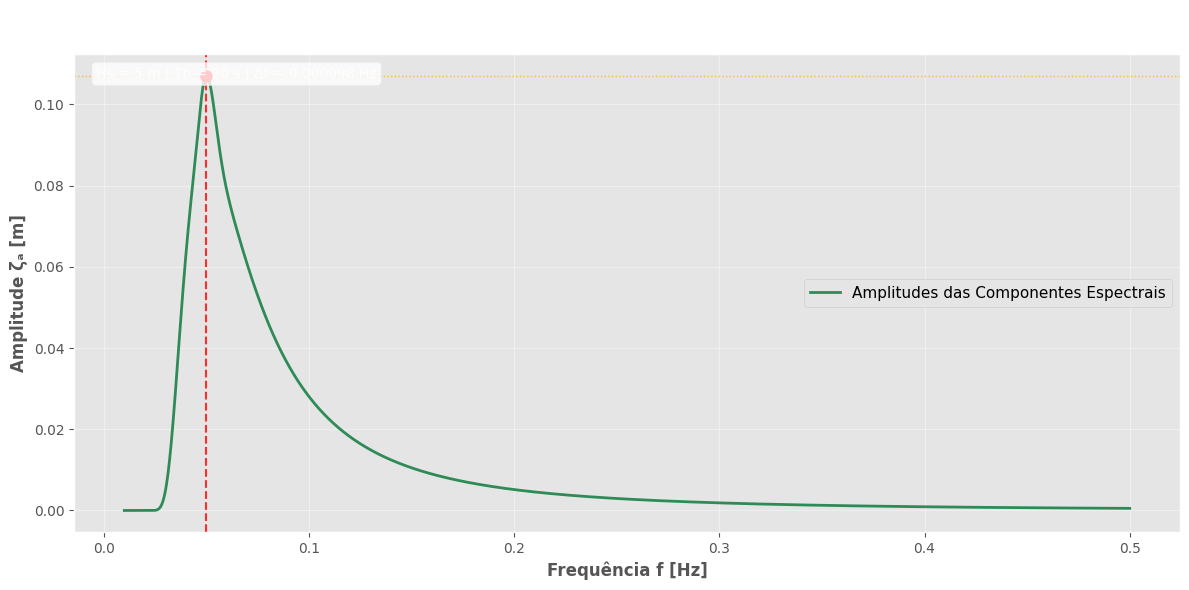

  ANÁLISE DAS AMPLITUDES ESPECTRAIS
Parâmetros do cálculo:
  • Resolução em frequência (Δf): 0.000098 Hz
  • Número de componentes: 5000
  • Faixa de frequência: 0.0100 - 0.5000 Hz

  Características das amplitudes:
  • Amplitude máxima: 0.1071 m em 0.0500 Hz
  • Amplitude média: 0.0119 m
  • Amplitude RMS: 0.0250 m

  VERIFICAÇÃO DA CONSERVAÇÃO DE ENERGIA:
  • Energia total do espectro (m₀): 1.557234 m²
  • Soma das energias das componentes: 1.557234 m²
  • Diferença: 0.000000 m²
  • Erro relativo: 0.0000 %

  ESTATÍSTICAS DAS AMPLITUDES:
  • Amplitude mínima: 0.000000 m
  • Amplitude máxima: 0.1071 m
  • Desvio padrão: 0.0219 m
  • Componentes com amplitude > 0.1 m: 64


In [30]:
# CÁLCULO DA AMPLITUDE DAS COMPONENTES ESPECTRAIS

# A amplitude de cada componente espectral (zeta_a) é calculada como:
# ζₐ(f) = √[2 · Δf · S(f)]
# Onde:
# - S(f): Densidade espectral de energia [m²·s]
# - Δf: Resolução em frequência [Hz]
# - ζₐ: Amplitude da componente de onda na frequência f [m]

# Este cálculo assume que a energia em cada banda de frequência Δf
# é concentrada em uma única componente senoidal com amplitude ζₐ
zeta_a = np.sqrt(2 * delta_f * Sf)

# VISUALIZAÇÃO DAS AMPLITUDES ESPECTRAIS
plt.figure(figsize=(12, 6))
plt.plot(f, zeta_a, linewidth=2, color='#2E8B57', 
         label='Amplitudes das Componentes Espectrais')

# Configurações do gráfico
plt.ylabel('Amplitude ζₐ [m]', fontsize=12, fontweight='bold')
plt.xlabel('Frequência f [Hz]', fontsize=12, fontweight='bold')
plt.title('Amplitudes das Componentes de Onda no Domínio da Frequência', 
          fontsize=14, fontweight='bold', pad=20)

plt.grid(True, alpha=0.6, linestyle='-', linewidth=0.5)
plt.legend(fontsize=11, framealpha=0.9)

# Adiciona linha vertical na frequência de pico
f_pico = 1 / tp
plt.axvline(x=f_pico, color='red', linestyle='--', alpha=0.8, 
            linewidth=1.5, label=f'Frequência de Pico (fₚ={f_pico:.3f} Hz)')

# Destaca a amplitude máxima
idx_max_amp = np.argmax(zeta_a)
f_max_amp = f[idx_max_amp]
zeta_max = zeta_a[idx_max_amp]

plt.axhline(y=zeta_max, color='orange', linestyle=':', alpha=0.7,
            linewidth=1, label=f'Amplitude Máxima: {zeta_max:.2f} m')

plt.plot(f_max_amp, zeta_max, 'ro', markersize=8, 
         label=f'Pico: ({f_max_amp:.3f} Hz, {zeta_max:.2f} m)')

# Ajusta limites para melhor visualização
#plt.xlim(0, 0.3)
#plt.ylim(0, zeta_max * 1.1)

# Adiciona informações no gráfico
plt.text(0.02, 0.95, f'Hs = {hs} m | Tp = {tp} s | Δf = {delta_f:.6f} Hz', 
         transform=plt.gca().transAxes, fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

# ANÁLISE DAS AMPLITUDES CALCULADAS
print("  ANÁLISE DAS AMPLITUDES ESPECTRAIS")
print("=" * 55)
print(f"Parâmetros do cálculo:")
print(f"  • Resolução em frequência (Δf): {delta_f:.6f} Hz")
print(f"  • Número de componentes: {len(zeta_a)}")
print(f"  • Faixa de frequência: {f[0]:.4f} - {f[-1]:.4f} Hz")

print(f"\n  Características das amplitudes:")
print(f"  • Amplitude máxima: {zeta_max:.4f} m em {f_max_amp:.4f} Hz")
print(f"  • Amplitude média: {np.mean(zeta_a):.4f} m")
print(f"  • Amplitude RMS: {np.sqrt(np.mean(zeta_a**2)):.4f} m")

# VERIFICAÇÃO DA CONSISTÊNCIA ENERGÉTICA
# A soma das energias das componentes deve aproximar m0
energia_componentes = np.sum(zeta_a**2 / 2)
m0_verificacao = np.trapezoid(Sf, f)

print(f"\n  VERIFICAÇÃO DA CONSERVAÇÃO DE ENERGIA:")
print(f"  • Energia total do espectro (m₀): {m0_verificacao:.6f} m²")
print(f"  • Soma das energias das componentes: {energia_componentes:.6f} m²")
print(f"  • Diferença: {abs(m0_verificacao - energia_componentes):.6f} m²")
print(f"  • Erro relativo: {abs((m0_verificacao - energia_componentes)/m0_verificacao)*100:.4f} %")

# DISTRIBUIÇÃO ESTATÍSTICA DAS AMPLITUDES
print(f"\n  ESTATÍSTICAS DAS AMPLITUDES:")
print(f"  • Amplitude mínima: {np.min(zeta_a):.6f} m")
print(f"  • Amplitude máxima: {np.max(zeta_a):.4f} m")
print(f"  • Desvio padrão: {np.std(zeta_a):.4f} m")
print(f"  • Componentes com amplitude > 0.1 m: {np.sum(zeta_a > 0.1)}")

# RAO numérico do navio

Análise e Visualização de RAO (Response Amplitude Operator)

Este script processa e visualiza dados de RAO (obtido através de um modelo computacional), que representa a resposta dinâmica de uma estrutura flutuante às ondas do mar.

O Response Amplitude Operator (RAO) é uma função de transferência que relaciona a amplitude da resposta de uma estrutura flutuante com a amplitude das ondas incidentes, em função da frequência.

- Magnitude do RAO: Indica quanto a estrutura responde para cada frequência
- Valores próximos a 1: A estrutura acompanha o movimento das ondas
- Valores >> 1: Ressonância (amplificação da resposta)
- Valores << 1: A estrutura é menos afetada por aquela frequência

Aplicações:
- Projeto de plataformas offshore
- Análise de navios e embarcações
- Estudos de movimento em 6 graus de liberdade (heave, pitch, roll, etc.)

In [31]:
# Carrega o RAO [w, real(RAO), imag(RAO)]
rao_data = np.array([[0.00999999253114992,1.000626,-0.001304847],
[0.0499998830785236,1.015586,-0.007924744],
[0.0999999253114992,1.065954,-0.0256068],
[0.150000007333373,1.159031,-0.07442564],
[0.175000078185924,1.221892,-0.1229897],
[0.200000168932916,1.292448,-0.1973969],
[0.224999742426387,1.364457,-0.3068606],
[0.250000410110318,1.425854,-0.4621112],
[0.275000560540776,1.4532,-0.6728624],
[0.299999298471141,1.40566,-0.9354835],
[0.324999627949226,1.236216,-1.208878],
[0.349999181549665,0.9352049,-1.407357],
[0.374999123088927,0.5715443,-1.451135],
[0.399999064628189,0.255577,-1.342692],
[0.42499900616745,0.04731597,-1.157613],
[0.450001096298654,-0.06280198,-0.9670042],
[0.474998511255053,-0.1095895,-0.8031601],
[0.499998830785236,-0.1219991,-0.6717551],
[0.524998772324498,-0.1177207,-0.5685172],
[0.549998713863759,-0.1063931,-0.487183],
[0.574998884187273,-0.09290343,-0.4220923],
[0.599998596942283,-0.07947022,-0.3687671],
[0.624999781876196,-0.06680158,-0.3239916],
[0.649999928327242,-0.05496959,-0.2856781],
[0.675000194144612,-0.04388655,-0.25251],
[0.699999922813953,-0.03351789,-0.2236753],
[0.725000208525694,-0.02390925,-0.1985342],
[0.750000036666864,-0.01515082,-0.1766077],
[0.774999606181508,-0.007343339,-0.1574261],
[0.800000166435309,-0.0005663104,-0.1405595],
[0.825000237287859,0.005157016,-0.1255997],
[0.850000312119295,0.009882366,-0.1121679],
[0.875000390929618,0.01373685,-0.09997757],
[0.899999614282054,0.01686178,-0.08883087],
[0.925000376463842,0.01938278,-0.07862416],
[0.949999895247508,0.02138249,-0.06928597],
[0.975000396813239,0.02289039,-0.06080105],
[0.999999253114992,0.02392741,-0.05309147],
[1.02499947914328,0.02451225,-0.04607917],
[1.04999929932697,0.0246883,-0.03968797],
[1.0750006513767,0.0245215,-0.03386452],
[1.09999935349669,0.02406415,-0.02857455],
[1.12500072643568,0.02336604,-0.02380708],
[1.14999987319435,0.02245245,-0.0195329],
[1.17500038470723,0.02135502,-0.0157248],
[1.1999994857094,0.02011512,-0.01235669],
[1.22500020611285,0.01876117,-0.009397379],
[1.24999956375239,0.01733484,-0.006831634],
[1.27499960575804,0.01585459,-0.00462771],
[1.29999985665448,0.01435427,-0.002757248],
[1.32499906309736,0.01286535,-0.001194537],
[1.35000038828922,0.01141375,7.887054e-05],
[1.37499979367505,0.010009,0.001085244],
[1.39999984562791,0.008665669,0.001860468],
[1.42500092015186,0.007401119,0.002439321],
[1.45000041705139,0.006231181,0.002842027],
[1.47499883965632,0.005160025,0.003085382],
[1.50000007333373,0.004188926,0.003197805],
[1.52500055997874,0.003317361,0.003204818],
[1.54999921236302,0.002551197,0.003131752]])

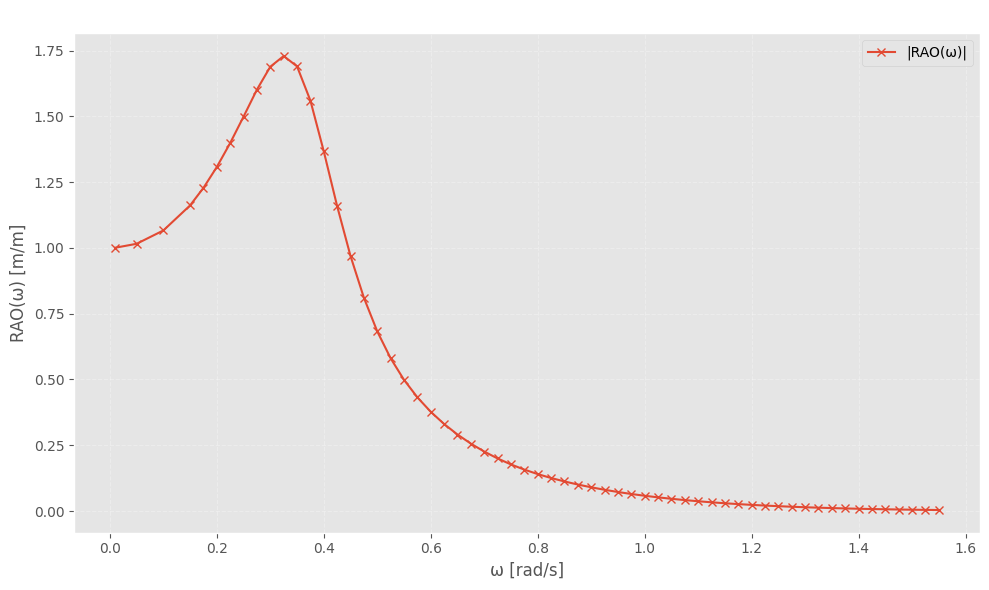

In [32]:
# Extrai as frequências angulares (ω) da primeira coluna
w_rao = rao_data[:, 0]

# Reconstrói o RAO complexo a partir das partes real e imaginária
# RAO complexo = Real(RAO) + i*Imag(RAO)
rao_complex = rao_data[:, 1] + 1j * rao_data[:, 2]


# VISUALIZAÇÃO DO RAO

# Configuração da figura
plt.figure(figsize=(10, 6))

# Plota a magnitude do RAO em função da frequência angular
# O 'x-' indica marcadores 'x' conectados por linhas
plt.plot(w_rao, np.abs(rao_complex), 'x-', 
         linewidth=1.5, markersize=6, label='|RAO(ω)|')

# Configuração dos rótulos e título
plt.ylabel('RAO(ω) [m/m]', fontsize=12)
plt.xlabel('ω [rad/s]', fontsize=12)
plt.title('Operador de Amplitude de Resposta (RAO)', fontsize=14, fontweight='bold')

# Adiciona grade para melhor leitura
plt.grid(True, alpha=0.3, linestyle='--')

# Adiciona legenda
plt.legend(loc='best')

# Ajusta o layout para evitar cortes
plt.tight_layout()

# Opcional: Limita o intervalo do eixo x para focar em região específica
# Descomente a linha abaixo se necessário
# plt.xlim(0.2, 0.4)

# Exibe o gráfico
plt.show()

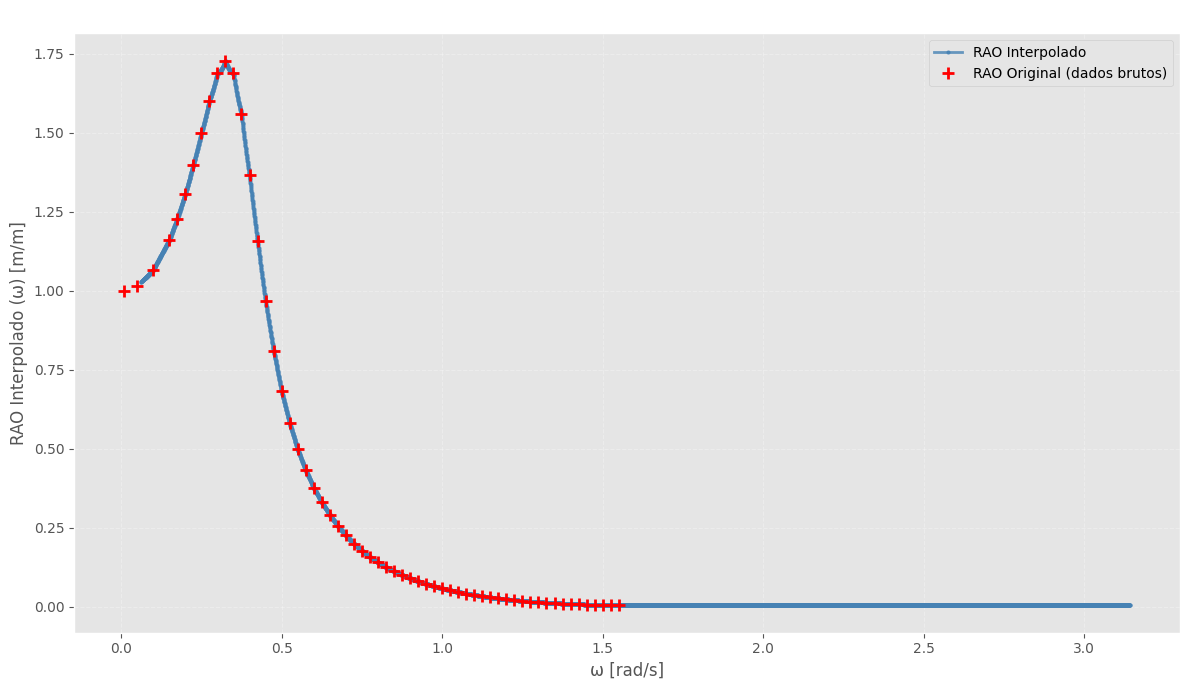

In [33]:
# INTERPOLAÇÃO DO RAO

# Nova malha de frequências (mesma usada para o espectro)
w = np.linspace(2*pi/100, 2*pi/2, N)  

# Interpola o RAO para uma nova malha de frequências 'w'
# np.interp realiza interpolação linear 1D:
# - w: nova malha de frequências (pontos onde queremos o RAO)
# - w_rao: frequências originais dos dados de RAO
# - rao: valores complexos do RAO original
rao_interpolado = np.interp(w, w_rao, rao_complex)


# VISUALIZAÇÃO COMPARATIVA

# Configuração da figura
plt.figure(figsize=(12, 7))

# Plota o RAO interpolado na nova malha de frequências
# '.-' indica pontos conectados por linha sólida
plt.plot(w, np.abs(rao_interpolado), '.-', 
         linewidth=2, markersize=4, 
         label='RAO Interpolado', color='steelblue', alpha=0.8)

# Plota os dados originais do RAO para comparação
# 'r+' indica marcadores vermelhos em forma de cruz
plt.plot(w_rao, np.abs(rao_complex), 'r+', 
         markersize=8, markeredgewidth=2,
         label='RAO Original (dados brutos)')

# Configuração dos rótulos e título
plt.ylabel('RAO Interpolado (ω) [m/m]', fontsize=12)
plt.xlabel('ω [rad/s]', fontsize=12)
plt.title('Comparação: RAO Original vs. Interpolado', fontsize=14, fontweight='bold')

# Adiciona grade para facilitar leitura
plt.grid(True, alpha=0.3, linestyle='--')

# Adiciona legenda com posição automática
plt.legend(loc='best', fontsize=10, framealpha=0.9)

# Ajusta o layout automaticamente
plt.tight_layout()
# plt.xlim(0.2, 0.4)

# Exibe o gráfico
plt.show()

Espectro de Resposta de Heave: descreve como a energia do movimento vertical da estrutura está distribuída ao longo das frequências

$$S_{heave} (\omega) = |RAO|^2 S_{mar} (\omega)$$

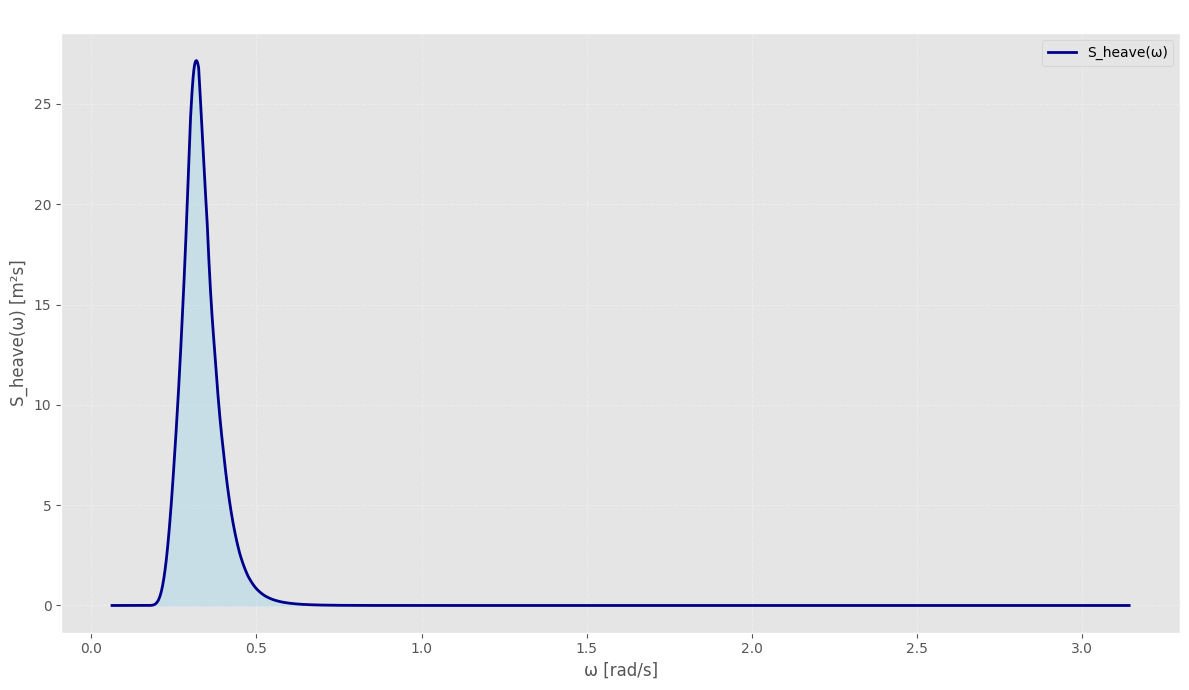

ESTATÍSTICAS DO MOVIMENTO DE HEAVE
Variância do heave:           3.0829 m²
Desvio padrão (RMS):          1.7558 m
Amplitude significativa:      7.0233 m


In [34]:
# CÁLCULO DO ESPECTRO DE RESPOSTA DE HEAVE


# Calcula o espectro de resposta de heave usando a relação fundamental:
# S_heave(ω) = |RAO(ω)|² × S_wave(ω)
# 
# Onde:
# - S_heave(ω): Espectro de densidade de energia do movimento de heave
# - |RAO(ω)|²: Magnitude ao quadrado do operador de amplitude de resposta
# - S_wave(ω): Espectro de densidade de energia das ondas incidentes

S_heave_w = (np.abs(rao_interpolado) ** 2) * Sw


# VISUALIZAÇÃO DO ESPECTRO DE HEAVE


# Configuração da figura
plt.figure(figsize=(12, 7))

# Plota o espectro de resposta de heave
plt.plot(w, S_heave_w, linewidth=2, color='darkblue', label='S_heave(ω)')

# Preenche a área sob a curva para melhor visualização da energia
plt.fill_between(w, S_heave_w, alpha=0.3, color='skyblue')

# Configuração dos rótulos e título
plt.ylabel('S_heave(ω) [m²s]', fontsize=12)
plt.xlabel('ω [rad/s]', fontsize=12)
plt.title('Espectro de Densidade de Energia - Movimento de Heave', 
          fontsize=14, fontweight='bold')

# Adiciona grade para facilitar leitura
plt.grid(True, alpha=0.3, linestyle='--')

# Adiciona legenda
plt.legend(loc='best', fontsize=10, framealpha=0.9)

# Ajusta o layout automaticamente
plt.tight_layout()

# Exibe o gráfico
plt.show()


# CÁLCULO DE ESTATÍSTICAS DO MOVIMENTO


# A área sob a curva do espectro representa a variância do movimento
# Integração numérica usando a regra dos trapézios
variancia_heave = np.trapezoid(S_heave_w, w)

# Desvio padrão do movimento de heave (RMS - Root Mean Square)
desvio_padrao_heave = np.sqrt(variancia_heave)

# Amplitude significativa (aproximadamente o valor médio do 1/3 das maiores amplitudes)
amplitude_significativa = 4 * desvio_padrao_heave

print("ESTATÍSTICAS DO MOVIMENTO DE HEAVE")
print("="*60)
print(f"Variância do heave:           {variancia_heave:.4f} m²")
print(f"Desvio padrão (RMS):          {desvio_padrao_heave:.4f} m")
print(f"Amplitude significativa:      {amplitude_significativa:.4f} m")

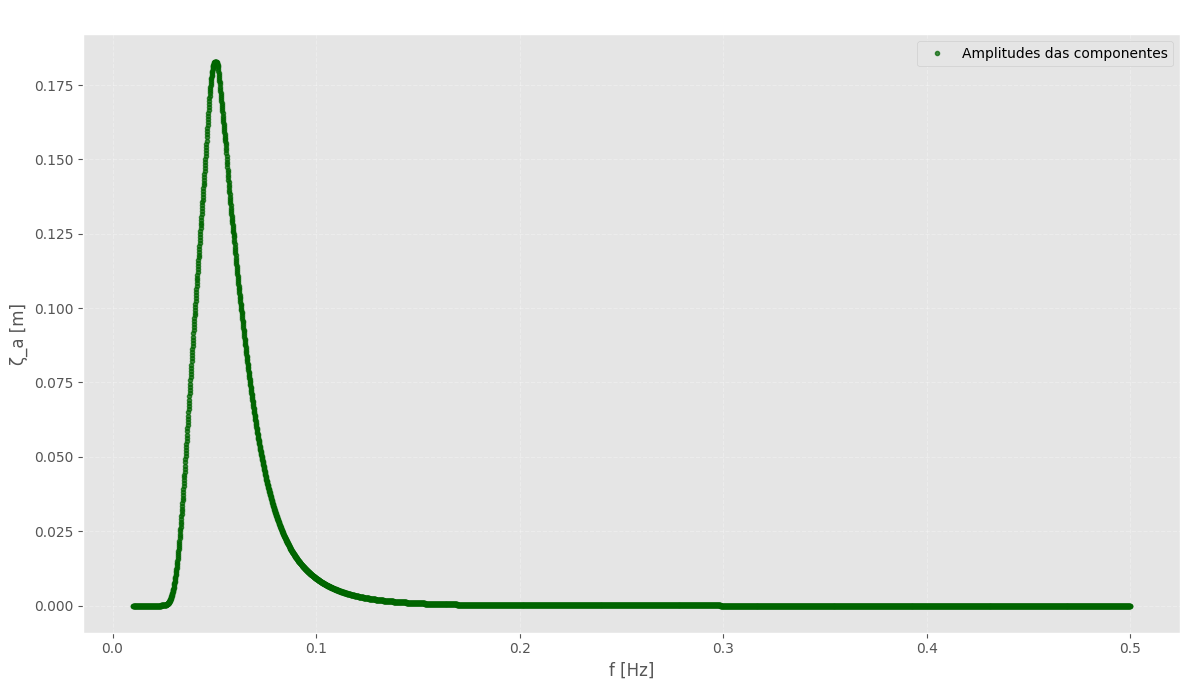

In [ ]:
# CÁLCULO DAS AMPLITUDES DE HEAVE
# Calcula as amplitudes de cada componente harmônica do movimento
# 
# A partir do espectro de energia S_heave(f), podemos decompor o movimento
# em uma soma de ondas senoidais com diferentes frequências e amplitudes:
#
# ζ_a(f) = √(2 × Δf × S_heave(f))
#
# Onde:
# - ζ_a(f): Amplitude da componente de frequência f
# - Δf: Incremento de frequência (resolução espectral)
# - S_heave(f): Espectro de densidade de energia do heave

S_heave_f = S_heave_w * (2*np.pi)

zeta_heave = np.sqrt(2 * delta_f * S_heave_f)


# Configuração da figura
plt.figure(figsize=(12, 7))

# Plota as amplitudes das componentes harmônicas
# Os pontos representam cada componente discreta do movimento
plt.plot(f, np.abs(zeta_heave), '.', 
         markersize=6, color='darkgreen', alpha=0.7,
         label='Amplitudes das componentes')

# Adiciona linha conectando os pontos para melhor visualização
plt.plot(f, np.abs(zeta_heave), '-', 
         linewidth=0.5, color='green', alpha=0.3)

# Configuração dos rótulos e título
plt.ylabel('ζ_a [m]', fontsize=12)
plt.xlabel('f [Hz]', fontsize=12)
plt.title('Amplitudes das Componentes Harmônicas do Movimento de Heave', 
          fontsize=14, fontweight='bold')

# Adiciona grade para facilitar leitura
plt.grid(True, alpha=0.3, linestyle='--')

# Adiciona legenda
plt.legend(loc='best', fontsize=10, framealpha=0.9)

# Ajusta o layout automaticamente
plt.tight_layout()

# Exibe o gráfico
plt.show()

# Geração das Séries Temporais

* $A_i$ - Amplitude da componente de onda $i$;
* $\omega_i$ - frequência angular da componente de onda $i$;
* $\psi_i$ - fase da componente de onda $i$;

$y(t) = \sum_{i=1}^{\infty} A_i \cdot \sin{(\omega_i t + \psi_i)}$

Lembrando que:

$\omega_i  = \dfrac{2 \pi}{T_i}$

In [36]:
#vetor de tempo
t0=0
tf=1*60*60
Nt = 10*N
t = np.linspace(t0, tf, Nt)

import random
random.seed(10)
y = np.zeros((N,Nt))
yh = np.zeros((N,Nt))

for ii,fi,ai,hi in zip(range(N),f,zeta_a,zeta_heave):
  phi = random.uniform(0, 2*np.pi)
  y[ii,:]  = ai * np.sin(2*np.pi*fi*t + phi)
  yh[ii,:] = np.abs(hi) * np.sin(2*np.pi*fi*t + phi + np.angle(hi))

ys = np.sum(y,0)
yhs = np.sum(yh,0)

# Séries temporais

Dados de Entrada (geralmente obtidos de ensaio experimental)


Elevação do mar: $\zeta_a(t)$

Movimento de heave medido: $\zeta_{heave}(t)$

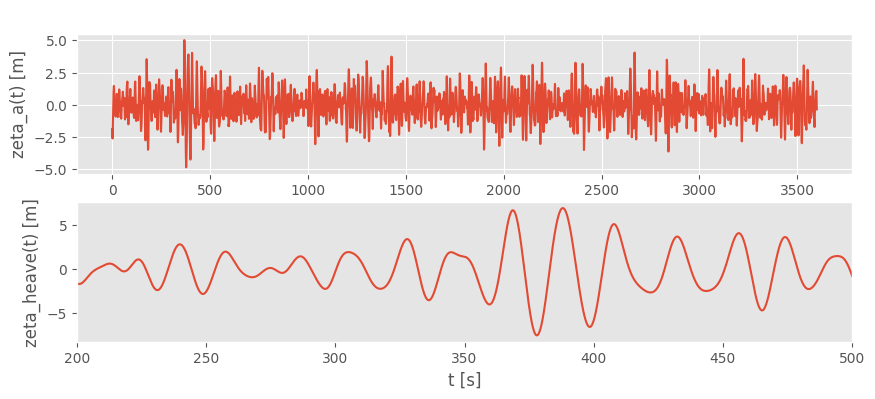

In [37]:
plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.plot(t, ys)
plt.ylabel('zeta_a(t) [m]')
plt.xlabel('t [s]')
# plt.xlim((0,200))
plt.title('Série Temporal da Onda (Hs={:.2f} m'.format(hs) + '/ Tp={:.1f} s)'.format(tp))

plt.subplot(2,1,2)
plt.plot(t, yhs)
plt.ylabel('zeta_heave(t) [m]')
plt.xlabel('t [s]')
# plt.title('Série Temporal do movimento')
plt.xlim((200,500))
plt.grid()
plt.show()

In [38]:
Hs_mar = 4*np.std(ys)
Hs_mar

np.float64(4.942210352097252)

In [39]:
Hs_navio = 4*np.std(yhs)
Hs_navio

np.float64(6.86617348835459)

# FFT da onda

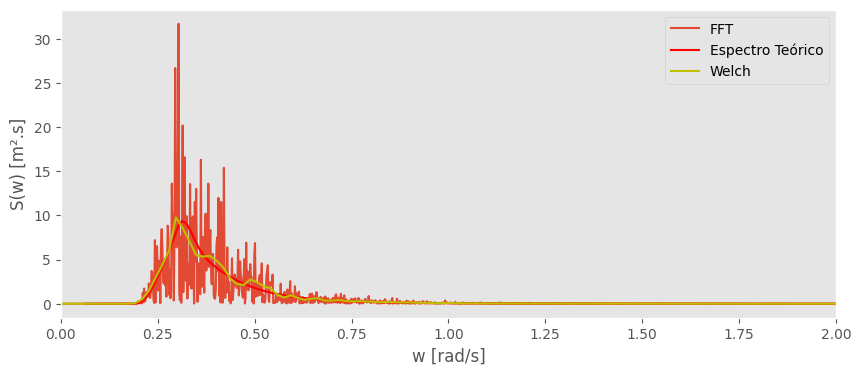

In [40]:
from scipy.fft import fft
from scipy.signal import welch

yf = fft(ys)
N1 = len(yf)

# vetor de frequencias
Delta_f = 1/(tf-t0)
f1 = np.arange(N1) * Delta_f

# remoção do aliasing
yf = 2*yf[0:N1//2]
w1 = 2*np.pi*f1[0:N1//2]

# Cálculo na frequencia angular
Delta_w = 2*np.pi*Delta_f
zeta_a1 = np.abs(yf)/N1
Sw1 = (zeta_a1**2)/(2*Delta_w)

#FFT utilizando o método welch
f_welch, Sf_welch = welch(ys, fs=1/(t[1]-t[0]), nperseg=int(len(ys)/10))
w_welch = f_welch*(2*pi)
Sw_welch = Sf_welch/(2*pi)

#plot dos espectros
plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(w1, Sw1)
plt.plot(w, Sw,'r')
plt.plot(w_welch, Sw_welch,'y')
plt.ylabel('S(w) [m².s]')
plt.xlabel('w [rad/s]')
plt.xlim((0,2))
plt.legend(('FFT', 'Espectro Teórico', 'Welch'))
plt.grid()
plt.show()

In [41]:
Hs_welch = 4*np.sqrt(np.trapzezoid(Sw_welch,w_welch))
Hs_welch

AttributeError: module 'numpy' has no attribute 'trapzezoid'

## Estatística das ondas:

### $H_s$: Altura significativa

$H_s = 4\sigma$

$\sigma = \sqrt{m_0}$

$m_n$: Momento espectral de ordem n

$m_n = \int_0^\infty \omega^n S(\omega) d \omega$

Ou seja,

$m_0 = \int_0^\infty S(\omega) d \omega$

### $T_z$: Período entre zeros ascendentes

$T_z = 2 \pi \sqrt{\dfrac{m_0}{m_2}}$

In [ ]:
m0 = np.trapzezoid(Sw1, w1)
m1 = np.trapzezoid((w1**1)*Sw1, w1)
m2 = np.trapzezoid((w1**2)*Sw1, w1)
m4 = np.trapzezoid((w1**4)*Sw1, w1)
Hs = 4*np.sqrt(m0)
Tz = 2*np.pi*np.sqrt(m0/m2)
Tc = 2*np.pi*(m0/m1)

print('Hs = ' + '{:.4f}'.format(Hs) + ' m')
print('Tz = ' + '{:.4f}'.format(Tz) + ' s')
print('Tc = ' + '{:.4f}'.format(Tc) + ' s')

Hs = 4.9422 m
Tz = 14.2888 s
Tc = 15.7265 s


/var/folders/ct/6tj9598n58x450wty030kyqc0000gn/T/ipykernel_9932/433261761.py:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  m0 = np.trapz(Sw1, w1)
/var/folders/ct/6tj9598n58x450wty030kyqc0000gn/T/ipykernel_9932/433261761.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  m1 = np.trapz((w1**1)*Sw1, w1)
/var/folders/ct/6tj9598n58x450wty030kyqc0000gn/T/ipykernel_9932/433261761.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  m2 = np.trapz((w1**2)*Sw1, w1)
/var/folders/ct/6tj9598n58x450wty030kyqc0000gn/T/ipykernel_9932/433261761.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  m4 = np.trapz((w1**4)*Sw1, w1)


# FFT do movimento do navio

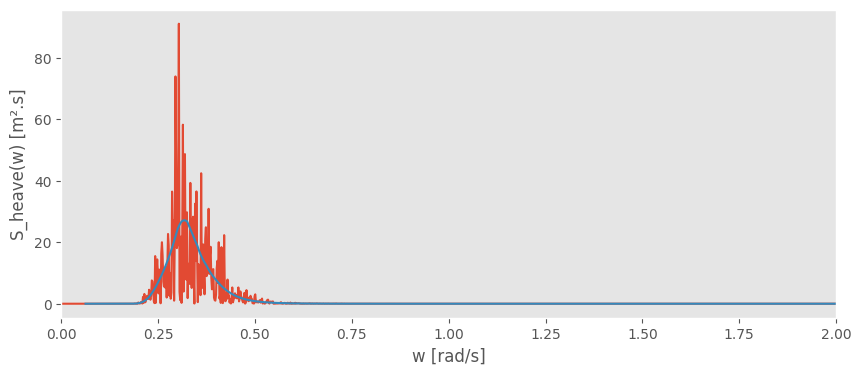

In [ ]:
yhf = fft(yhs)
N1 = len(yhf)

# vetor de frequencias
# Delta_f = 1/(tf-t0)
# f1 = np.arange(N1) * Delta_f

yhf = 2*yhf[0:N1//2]
# w1 = 2*np.pi*f1[0:N1//2]
# Delta_w = 2*np.pi*Delta_f
zeta_heave1 = np.abs(yhf)/N1
S_heave_w1 = (zeta_heave1**2)/(2*Delta_w)

plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(w1, np.abs(S_heave_w1))
plt.plot(w, np.abs(S_heave_w))
plt.ylabel('S_heave(w) [m².s]')
plt.xlabel('w [rad/s]')
plt.xlim((0,2))
plt.grid()
plt.show()

In [ ]:
m0 = np.trapzezoid(np.abs(S_heave_w1), w1)
m2 = np.trapzezoid((w1**2)*np.abs(S_heave_w1), w1)
Hs = 4*np.sqrt(m0)
Tz = 2*np.pi*np.sqrt(m0/m2)

print('Hs = ' + '{:.2f}'.format(Hs) + ' m')
print('Tz = ' + '{:.2f}'.format(Tz) + ' s')

Hs = 6.87 m
Tz = 17.89 s


/var/folders/ct/6tj9598n58x450wty030kyqc0000gn/T/ipykernel_9932/2237627071.py:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  m0 = np.trapz(np.abs(S_heave_w1), w1)
/var/folders/ct/6tj9598n58x450wty030kyqc0000gn/T/ipykernel_9932/2237627071.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  m2 = np.trapz((w1**2)*np.abs(S_heave_w1), w1)


# RAO do navio

$ S_{heave}(\omega) = [RAO]^2 \cdot S_{mar} (\omega)$

$RAO (\omega) = \sqrt{\dfrac{S_{heave}(\omega)}{S_{mar} (\omega)}}$

NameError: name 'rao_q' is not defined

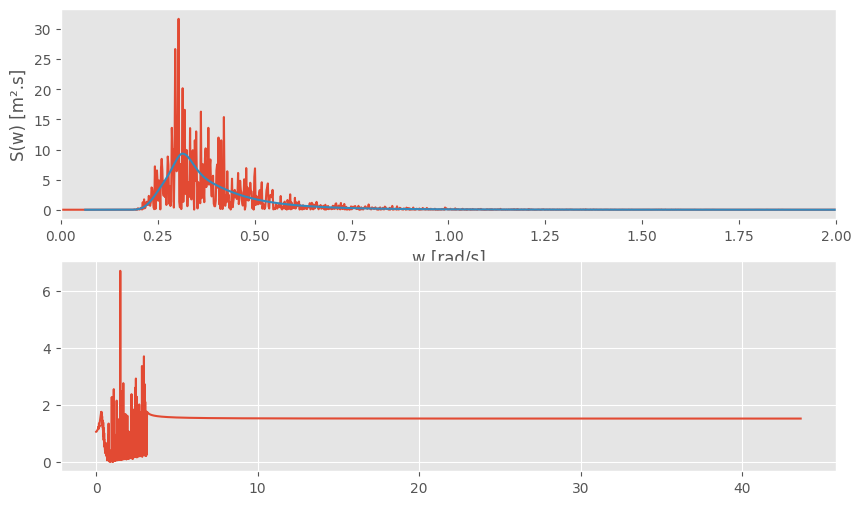

In [ ]:
RAO = np.sqrt(S_heave_w1 / Sw1)

plt.figure(figsize=(10,6), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.plot(w1, Sw1)
plt.plot(w, Sw)
plt.ylabel('S(w) [m².s]')
plt.xlabel('w [rad/s]')
plt.xlim((0,2))
plt.grid()
plt.subplot(2,1,2)
plt.plot(w1, RAO)
plt.plot(w, np.abs(rao_interpolado))
plt.xlim((0,2))
plt.ylim((0,2))
plt.ylabel('RAO (w) [m/m]')
plt.xlabel('w [rad/s]')
plt.grid()
plt.show()